In [1]:
import os
from zipfile import ZipFile
import matplotlib  # Used to set default paremeters
import matplotlib.gridspec as gridspec
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import het_goldfeldquandt, het_breuschpagan
from matplotlib import rcParams  # Used to set default paremeters
from scipy import stats
from sklearn.compose import make_column_transformer
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GridSearchCV,
    cross_val_predict,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    OneHotEncoder,
    LabelEncoder,
    LabelBinarizer,
    MinMaxScaler,
)

import xgboost as xgb

In [2]:
sns.set_theme(style="darkgrid")

# Set Default Fonts
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Arial", "Tahoma"]

# Set Default font sizes
small_size = 12
medium_size = 14
large_size = 16

# Change the font size for individual elements
matplotlib.rc("font", size=small_size)  # controls default text sizes
matplotlib.rc("axes", titlesize=small_size)  # fontsize of the axes title
matplotlib.rc("axes", labelsize=medium_size)  # fontsize of the x and y labels
matplotlib.rc("xtick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("ytick", labelsize=small_size)  # fontsize of the tick labels
matplotlib.rc("legend", fontsize=small_size)  # legend fontsize
matplotlib.rc("axes", titlesize=large_size)  # title fontsize


In [3]:
os.path.dirname(os.getcwd()) + "/data"

'/Users/albertovidalrodriguez-bobada/Library/Mobile Documents/com~apple~CloudDocs/Python/Projects/Linear regression - car price/data'

In [4]:
dataset_info = !kaggle datasets files thedevastator/uncovering-factors-that-affect-used-car-prices
dataset_name =  dataset_info[-1].split()[0]


path_data = os.path.dirname(os.getcwd()) + "/data"
path_zip = os.path.dirname(os.getcwd()) + "/data/uncovering-factors-that-affect-used-car-prices.zip"
path_file = os.path.dirname(os.getcwd()) + "/data/" + dataset_name

# if data is already donwloaded, print a statement to remind me
if os.path.exists(path_file):
    print("Data has already been downloaded")
# otherwise, download the data
else:
    # download data using kaggle API
    !kaggle datasets download -d thedevastator/uncovering-factors-that-affect-used-car-prices -p ../data

    # extract files in .zip folder
    with ZipFile(path_zip) as zObject:
        zObject.extractall(path=path_data)

    # delete .zip folder
    if os.path.exists(path_zip):
        os.remove(path_zip)
    else:
        print(".zip file already deleted")

Data has already been downloaded


# EDA and Feature Engineering
## Data understanding

In [5]:
data = pd.read_csv("../data/autos.csv", index_col=0)

# Only interested in German cars
data = data.loc[
    (data["brand"] == "bmw")
    | (data["brand"] == "audi")
    | (data["brand"] == "volkswagen")
    | (data["brand"] == "mercedes_benz")
    | (data["brand"] == "opel"),
    :
].reset_index(drop=True)

data.head(7)


dateCrawled                                               name  \
0  2016-03-24 11:52:17                                         Golf_3_1.6   
1  2016-03-24 10:58:45                               A5_Sportback_2.7_Tdi   
2  2016-03-17 16:54:04                                 GOLF_4_1_4__3TÜRER   
3  2016-04-04 17:36:23  BMW_316i___e36_Limousine___Bastlerfahrzeug__Ex...   
4  2016-03-21 18:54:38                       VW_Derby_Bj_80__Scheunenfund   
5  2016-03-17 10:53:50  VW_Golf_4_5_tuerig_zu_verkaufen_mit_Anhaengerk...   
6  2016-04-07 10:06:22      Volkswagen_Passat_Variant_2.0_TDI_Comfortline   

   seller offerType  price   abtest vehicleType  yearOfRegistration  gearbox  \
0  privat   Angebot    480     test         NaN                1993  manuell   
1  privat   Angebot  18300     test       coupe                2011  manuell   
2  privat   Angebot   1500     test  kleinwagen                2001  manuell   
3  privat   Angebot    650     test   limousine                1995  manuell   
4  privat   Angebot      0     test   limousine                1980  manuell   
5  privat   Angebot    999     test  kleinwagen                1998  manuell   
6  privat   Angebot   2799  control       kombi                2005  manuell   

   powerPS   model  kilometer  monthOfRegistration fuelType       brand  \
0        0    golf     150000                    0   benzin  volkswagen   
1      190     NaN     125000                    5   diesel        audi   
2       75    golf     150000                    6   benzin  volkswagen   
3      102     3er     150000                   10   benzin         bmw   
4       50  andere      40000                    7   benzin  volkswagen   
5      101    golf     150000                    0      NaN  volkswagen   
6      140  passat     150000                   12   diesel  volkswagen   

  notRepairedDamage          dateCreated  nrOfPictures  postalCode  \
0               NaN  2016-03-24 00:00:00             0       70435   
1                ja  2016-03-24 00:00:00             0       66954   
2              nein  2016-03-17 00:00:00             0       91074   
3                ja  2016-04-04 00:00:00             0       33775   
4              nein  2016-03-21 00:00:00             0       19348   
5               NaN  2016-03-17 00:00:00             0       27472   
6                ja  2016-04-07 00:00:00             0       57290   

              lastSeen  
0  2016-04-07 03:16:57  
1  2016-04-07 01:46:50  
2  2016-03-17 17:40:17  
3  2016-04-06 19:17:07  
4  2016-03-25 16:47:58  
5  2016-03-31 17:17:06  
6  2016-04-07 10:25:17

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228232 entries, 0 to 228231
Data columns (total 20 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   dateCrawled          228232 non-null  object
 1   name                 228232 non-null  object
 2   seller               228232 non-null  object
 3   offerType            228232 non-null  object
 4   price                228232 non-null  int64 
 5   abtest               228232 non-null  object
 6   vehicleType          205606 non-null  object
 7   yearOfRegistration   228232 non-null  int64 
 8   gearbox              216993 non-null  object
 9   powerPS              228232 non-null  int64 
 10  model                218291 non-null  object
 11  kilometer            228232 non-null  int64 
 12  monthOfRegistration  228232 non-null  int64 
 13  fuelType             208642 non-null  object
 14  brand                228232 non-null  object
 15  notRepairedDamage    184016 non-nu

In [7]:
data.describe()

price  yearOfRegistration        powerPS      kilometer  \
count  2.282320e+05       228232.000000  228232.000000  228232.000000   
mean   1.321101e+04         2004.057389     125.857220  129860.339479   
std    7.648302e+05           78.503991     203.981543   37742.381405   
min    0.000000e+00         1000.000000       0.000000    5000.000000   
25%    1.300000e+03         1999.000000      75.000000  125000.000000   
50%    3.450000e+03         2003.000000     116.000000  150000.000000   
75%    8.450000e+03         2008.000000     163.000000  150000.000000   
max    1.000000e+08         9999.000000   20000.000000  150000.000000   

       monthOfRegistration  nrOfPictures     postalCode  
count        228232.000000      228232.0  228232.000000  
mean              5.789679           0.0   51318.138876  
std               3.724106           0.0   25911.301362  
min               0.000000           0.0    1067.000000  
25%               3.000000           0.0   30880.000000  
50%               6.000000           0.0   49744.000000  
75%               9.000000           0.0   72488.000000  
max              12.000000           0.0   99998.000000

## Data preparation

The first step in the data preparation process is to remove duplicates

In [8]:
data.duplicated(
    subset=[
        "name",
        "price",
        "yearOfRegistration",
        "gearbox",
        "kilometer",
        "fuelType",
        "monthOfRegistration",
        "dateCreated",
        "postalCode",
        "lastSeen",
    ],
).value_counts()

False    228208
True         24
dtype: int64

In [9]:

data.drop_duplicates(
    subset=[
        "name",
        "price",
        "yearOfRegistration",
        "gearbox",
        "kilometer",
        "fuelType",
        "monthOfRegistration",
        "dateCreated",
        "postalCode",
        "lastSeen",
    ],
    ignore_index=True,
    inplace=True
)

The next step is to drop irrelevant features. I will first capture the year when the data was added. In the future, I would like to add more datapoints and it would be great to keep track of the year when they were all added.

In [10]:
data["yearCreated"] = pd.to_datetime(data["dateCreated"]).dt.year

data.drop(
    [
        "name",
        "seller",
        "offerType",
        "dateCrawled",
        "abtest",
        "dateCreated",
        "notRepairedDamage",
        "nrOfPictures",
        "postalCode",
        "lastSeen",
        "monthOfRegistration",
        "yearCreated"
    ],
    axis=1,
    inplace=True,
)

data.head()

price vehicleType  yearOfRegistration  gearbox  powerPS   model  kilometer  \
0    480         NaN                1993  manuell        0    golf     150000   
1  18300       coupe                2011  manuell      190     NaN     125000   
2   1500  kleinwagen                2001  manuell       75    golf     150000   
3    650   limousine                1995  manuell      102     3er     150000   
4      0   limousine                1980  manuell       50  andere      40000   

  fuelType       brand  
0   benzin  volkswagen  
1   diesel        audi  
2   benzin  volkswagen  
3   benzin         bmw  
4   benzin  volkswagen

After removing duplicates, we need to deal with `NaN` values.

In [11]:
data.isna().sum()

price                     0
vehicleType           22626
yearOfRegistration        0
gearbox               11239
powerPS                   0
model                  9941
kilometer                 0
fuelType              19590
brand                     0
dtype: int64

In [12]:
data.dropna(axis=0, subset=["gearbox", "fuelType"], inplace=True)
data.reset_index(drop=True, inplace=True)
data.isna().sum()

price                     0
vehicleType           10621
yearOfRegistration        0
gearbox                   0
powerPS                   0
model                  5510
kilometer                 0
fuelType                  0
brand                     0
dtype: int64

Since the dataset contains some German words, I will replace them using the equivalent English words.

In [13]:
data["gearbox"].replace({"manuell": "Manual", "automatik": "Automatic"}, inplace=True)
data["fuelType"].replace({"benzin": "Petrol", "diesel": "Diesel"}, inplace=True)
data["model"].replace({"andere": "unknown"}, inplace=True)
data["vehicleType"].replace({"andere": "unknown"}, inplace=True)

Some of the columns include the word "andere", whiche means "unknown" in English. In the next sections I will perform feature engineering and create new features based on the car model. Therefore, unknown car models need to removed.

In [14]:

data = data[data["model"] != "unknown"].reset_index(drop=True)

In [15]:
data = data.loc[
    (data["fuelType"] == "Petrol") | (data["fuelType"] == "Diesel"), :
].reset_index(drop=True)

### Feature Engineering

In [16]:
data["powerHP"] = data["powerPS"] * 0.98632
data.drop(columns=["powerPS"], inplace=True)

In [17]:
data.head()

price vehicleType  yearOfRegistration gearbox   model  kilometer fuelType  \
0    480         NaN                1993  Manual    golf     150000   Petrol   
1  18300       coupe                2011  Manual     NaN     125000   Diesel   
2   1500  kleinwagen                2001  Manual    golf     150000   Petrol   
3    650   limousine                1995  Manual     3er     150000   Petrol   
4   2799       kombi                2005  Manual  passat     150000   Diesel   

        brand    powerHP  
0  volkswagen    0.00000  
1        audi  187.40080  
2  volkswagen   73.97400  
3         bmw  100.60464  
4  volkswagen  138.08480

In [18]:
transformer = make_column_transformer(
    (OneHotEncoder(drop="first"), ["gearbox", "fuelType"]),
    remainder="drop",
)

transformed = transformer.fit_transform(data)
data_transformed = pd.DataFrame(
    transformed, columns=transformer.get_feature_names_out()
)

data["gearbox"] = data_transformed["onehotencoder__gearbox_Manual"]
data["fuelType"] = data_transformed["onehotencoder__fuelType_Petrol"]

data["gearbox"] = data["gearbox"].astype(int)
data["fuelType"] = data["fuelType"].astype(int)

## Feature understanding and outliers

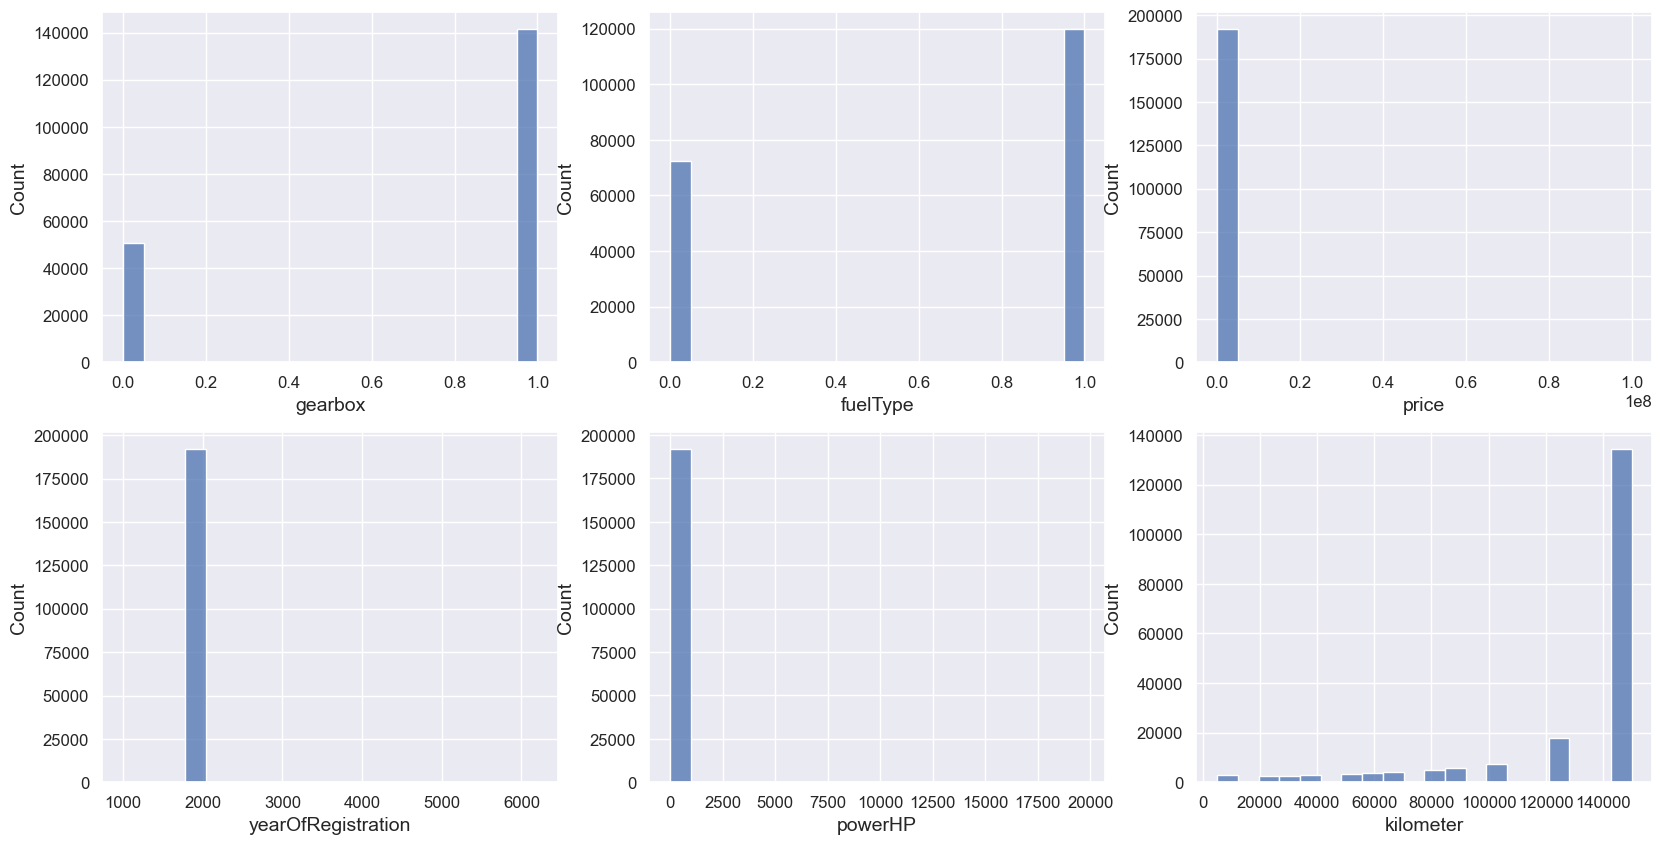

In [19]:
hist_features = [
    "gearbox",
    "fuelType",
    "price",
    "yearOfRegistration",
    "powerHP",
    "kilometer",
]

fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, feature in enumerate(hist_features):
    sns.histplot(x=data[feature], data=data, ax=axes[i], bins=20)

### Price


In [20]:
data = data[(data["price"] > 300) & (data["price"] < 60000)].reset_index(drop=True)

<AxesSubplot: xlabel='price', ylabel='brand'>

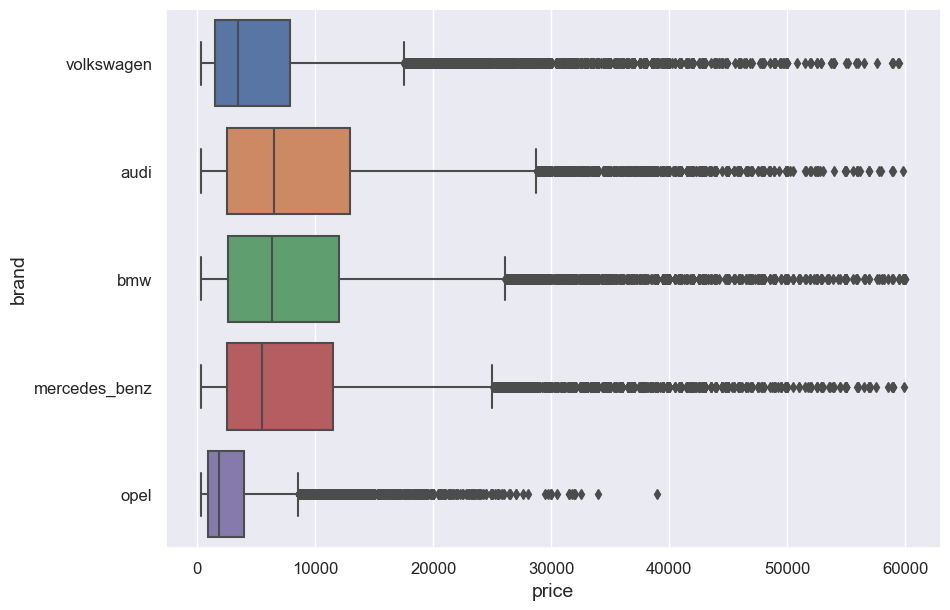

In [21]:
fig, ax = plt.subplots(figsize=(10,7))

sns.boxplot(x="price", y="brand", data=data, ax=ax)

<AxesSubplot: xlabel='price', ylabel='Count'>

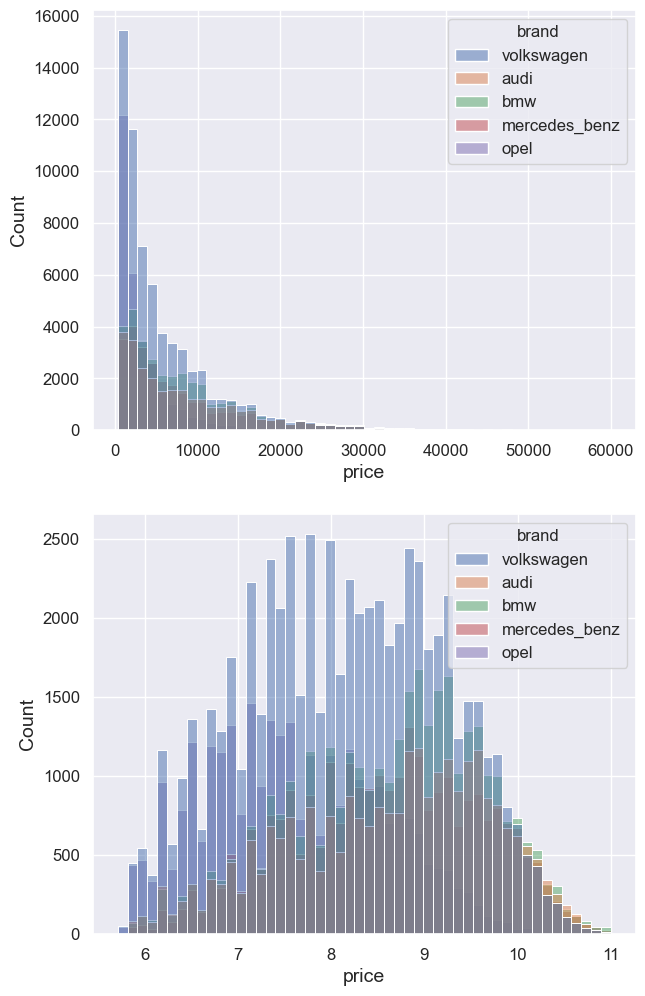

In [22]:
fig, axes = plt.subplots(2,1,figsize=(7,12))

sns.histplot(x="price", hue="brand", data=data, bins=50, ax=axes[0])
sns.histplot(x=np.log(data["price"]), hue="brand", data=data, bins=50, ax=axes[1])

### Power

In [23]:
upper_threshold = 250

mask_opel = ((data["powerHP"] < 40) | (data["powerHP"] > upper_threshold)) & (
    data["brand"] == "opel"
)
mask_volks = ((data["powerHP"] < 40) | (data["powerHP"] > upper_threshold)) & (
    data["brand"] == "volkswagen"
)
mask_audi = ((data["powerHP"] < 40) | (data["powerHP"] > upper_threshold)) & (
    data["brand"] == "audi"
)
mask_mercedes = ((data["powerHP"] < 40) | (data["powerHP"] > upper_threshold)) & (
    data["brand"] == "mercedes_benz"
)
mask_bmw = ((data["powerHP"] < 40) | (data["powerHP"] > upper_threshold)) & (
    data["brand"] == "bmw"
)
mask = mask_opel | mask_volks | mask_audi | mask_mercedes | mask_bmw

data = data[~mask].reset_index(drop=True)

<AxesSubplot: xlabel='powerHP', ylabel='brand'>

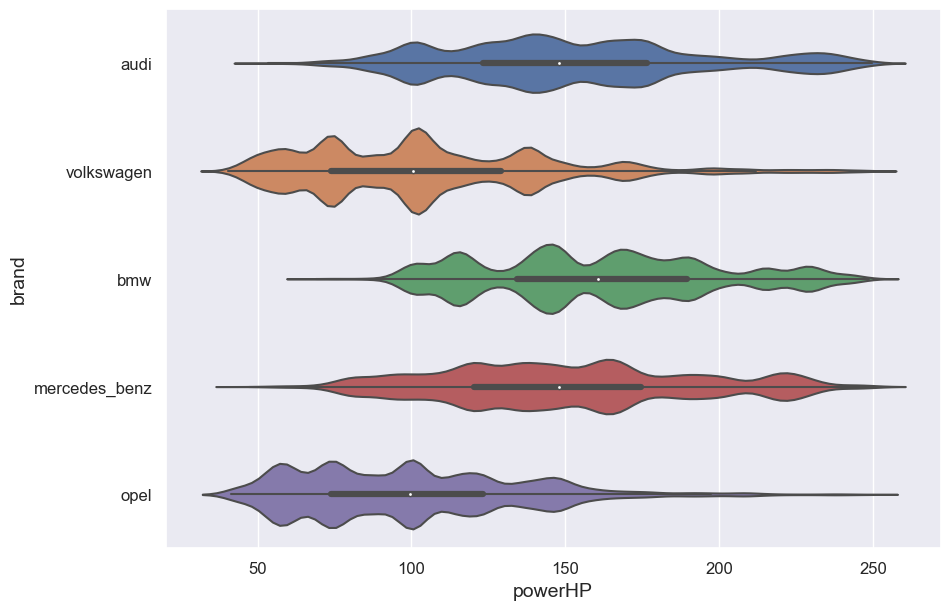

In [24]:
fig, ax = plt.subplots(figsize=(10,7))

sns.violinplot(x="powerHP", y="brand", data=data, ax=ax)

<AxesSubplot: xlabel='powerHP', ylabel='Count'>

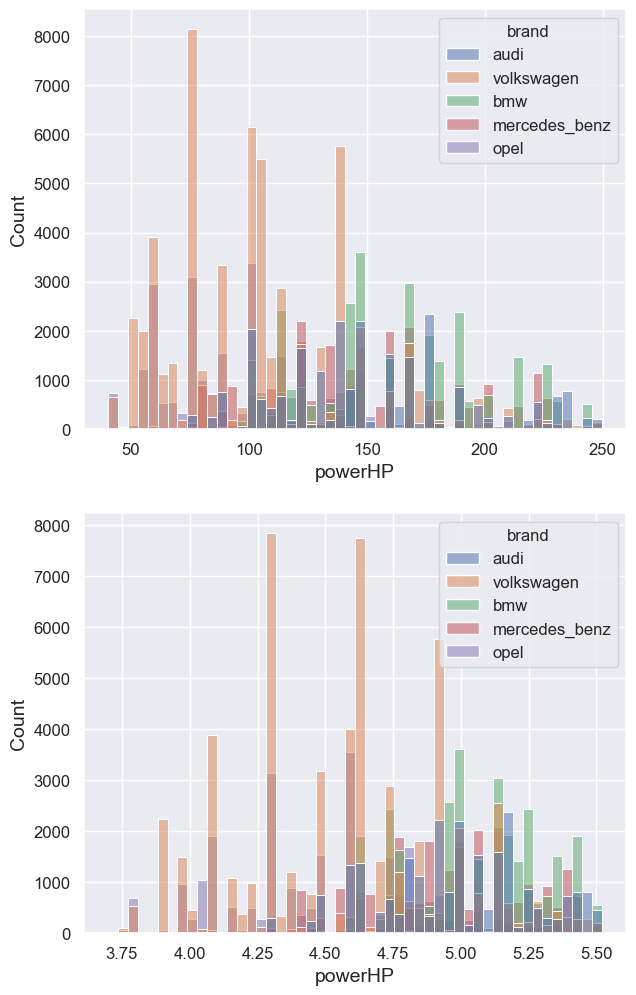

In [25]:
fig, axes = plt.subplots(2,1,figsize=(7,12))

sns.histplot(x="powerHP", hue="brand", data=data, bins=50, ax=axes[0])
sns.histplot(x=np.log(data["powerHP"]), hue="brand", data=data, bins=50, ax=axes[1])

### Year of registration

In [26]:
data.loc[
    (data["yearOfRegistration"] > 1974) & (data["yearOfRegistration"] < 1990),
    "yearOfRegistration",
].value_counts().to_frame()

yearOfRegistration
1989                 532
1988                 424
1987                 308
1986                 215
1985                 209
1983                 145
1984                 134
1982                 109
1979                  84
1978                  79
1981                  69
1980                  68
1977                  37
1976                  37
1975                  30

In [27]:
data = data[
    (data["yearOfRegistration"] > 1978) & (data["yearOfRegistration"] < 2016)
].reset_index(drop=True)

<AxesSubplot: xlabel='yearOfRegistration', ylabel='brand'>

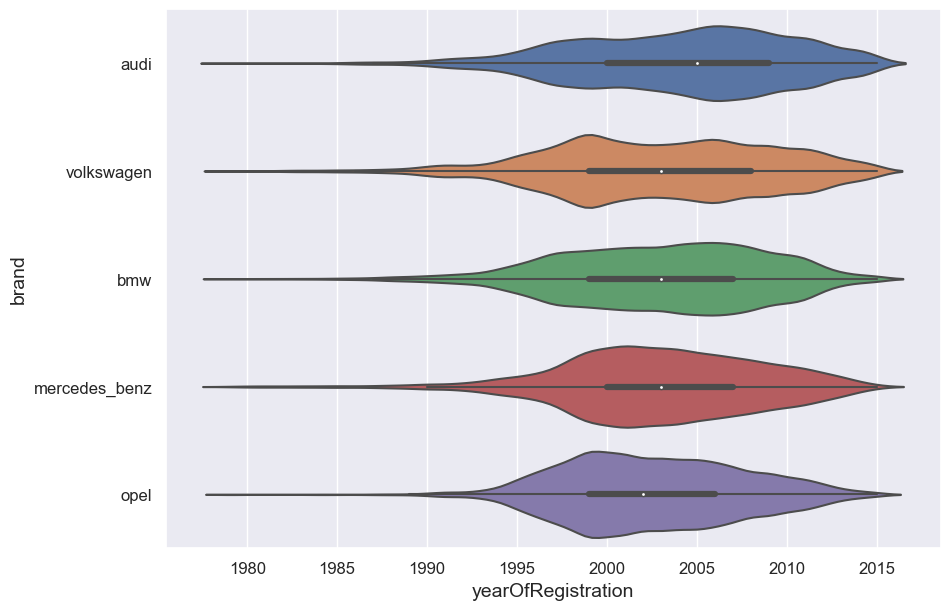

In [28]:
fig, ax = plt.subplots(figsize=(10,7))
sns.violinplot(x="yearOfRegistration", y="brand", data=data, ax=ax)

<AxesSubplot: xlabel='yearOfRegistration', ylabel='Count'>

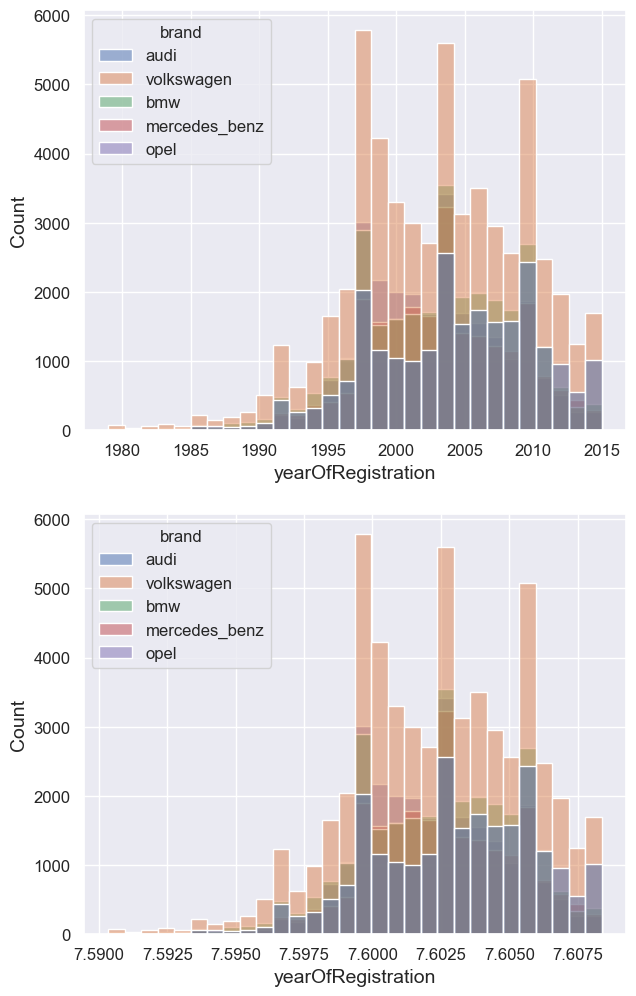

In [29]:
fig, axes = plt.subplots(2,1,figsize=(7,12))

sns.histplot(x="yearOfRegistration", hue="brand", data=data, bins=30, ax=axes[0])
sns.histplot(x=np.log(data["yearOfRegistration"]), hue="brand", data=data, bins=30, ax=axes[1])

## Feature Relationships

In [30]:
data["price"] = np.log(data["price"])

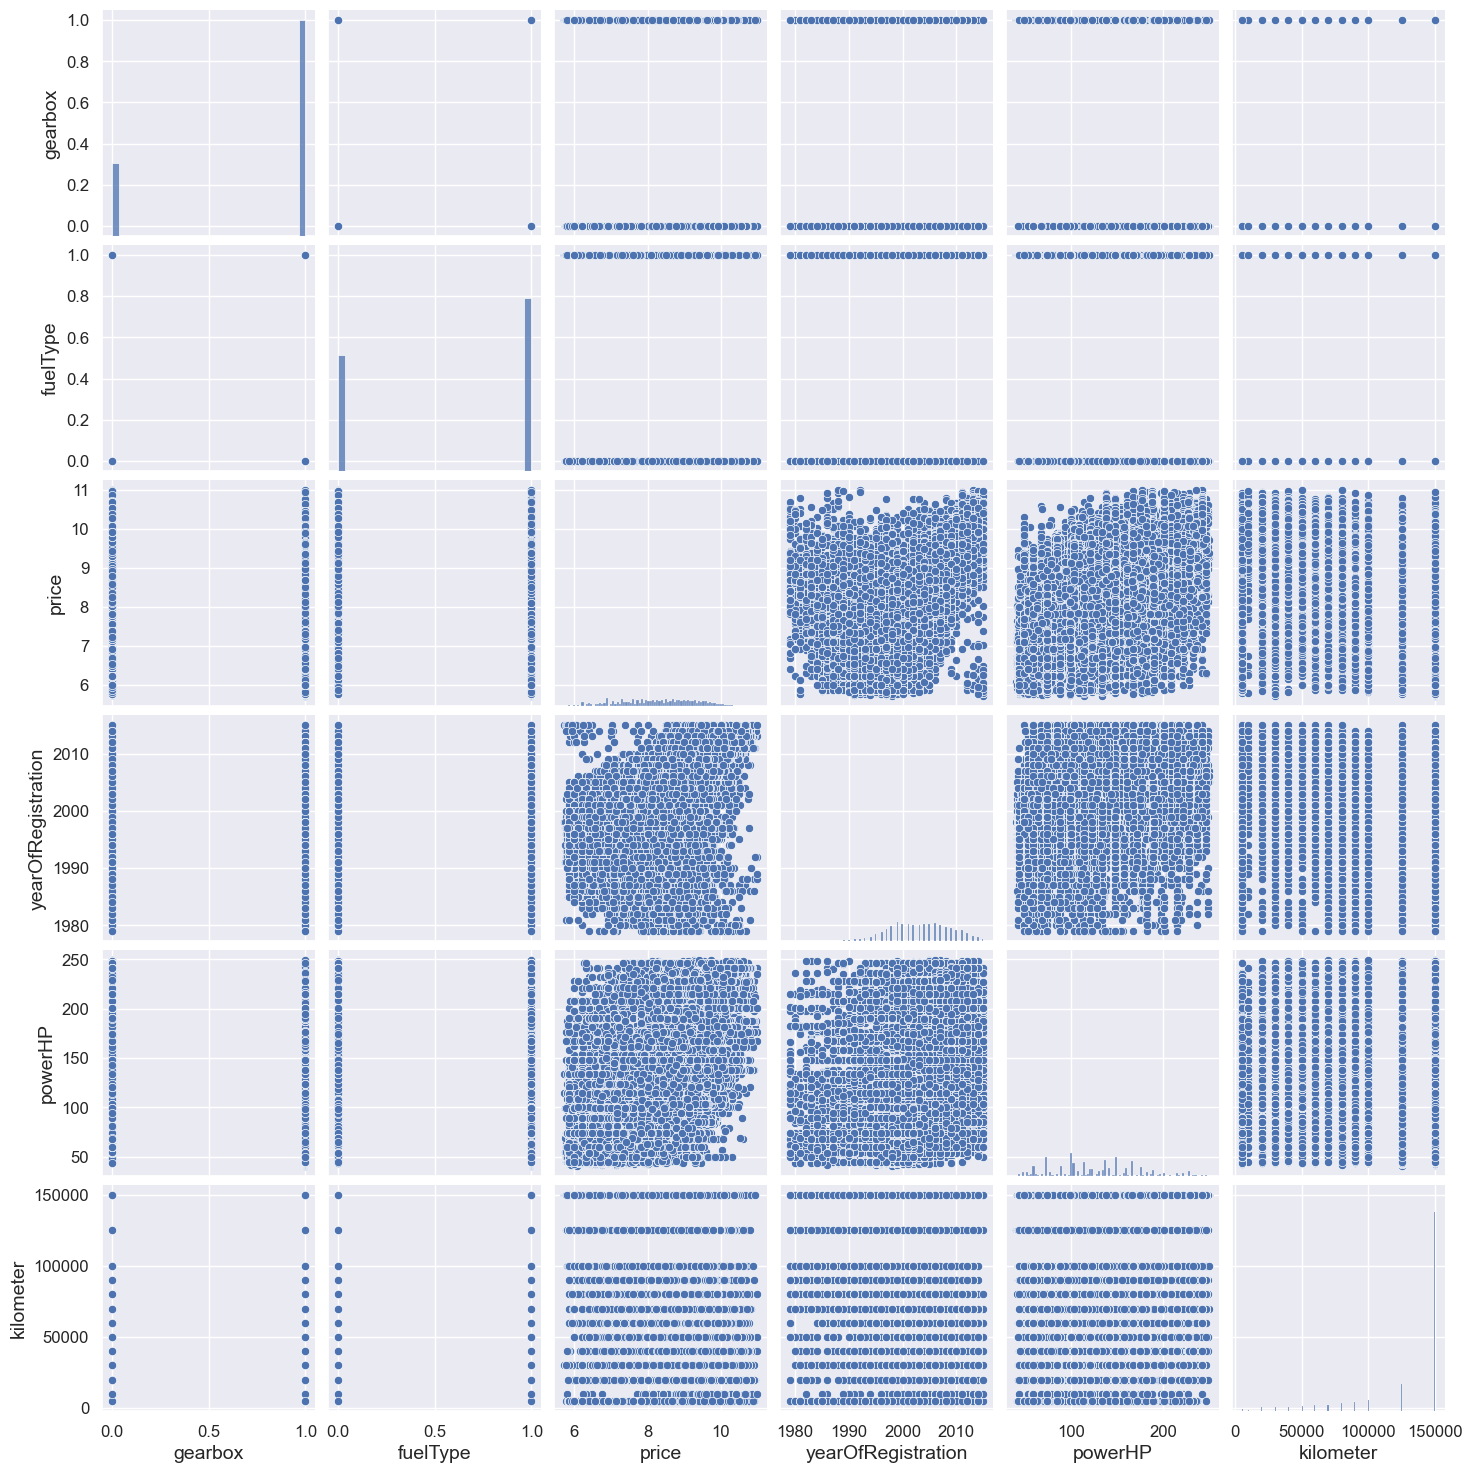

In [31]:
pairplot_features = hist_features.copy()
pairplot_features.append("brand")
sns.pairplot(data=data[pairplot_features])

/var/folders/87/0c9vcs_11172l6932m_lk5x40000gn/T/ipykernel_23948/1543510467.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(data.corr(), annot=True, fmt=".2f");


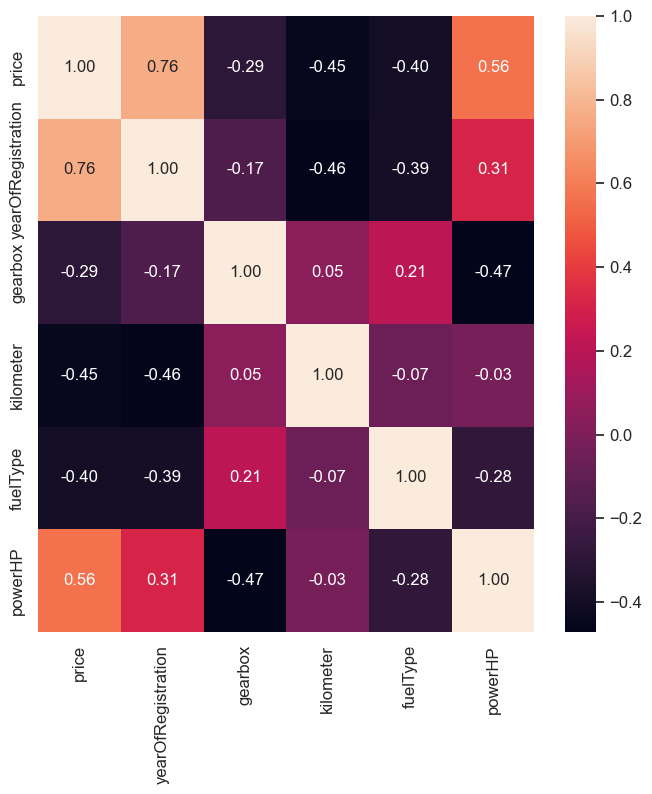

In [32]:
plt.figure(figsize=(8, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f");


/var/folders/87/0c9vcs_11172l6932m_lk5x40000gn/T/ipykernel_23948/3474253711.py:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_df = data_brand.corr()["price"].sort_values()[:-1]


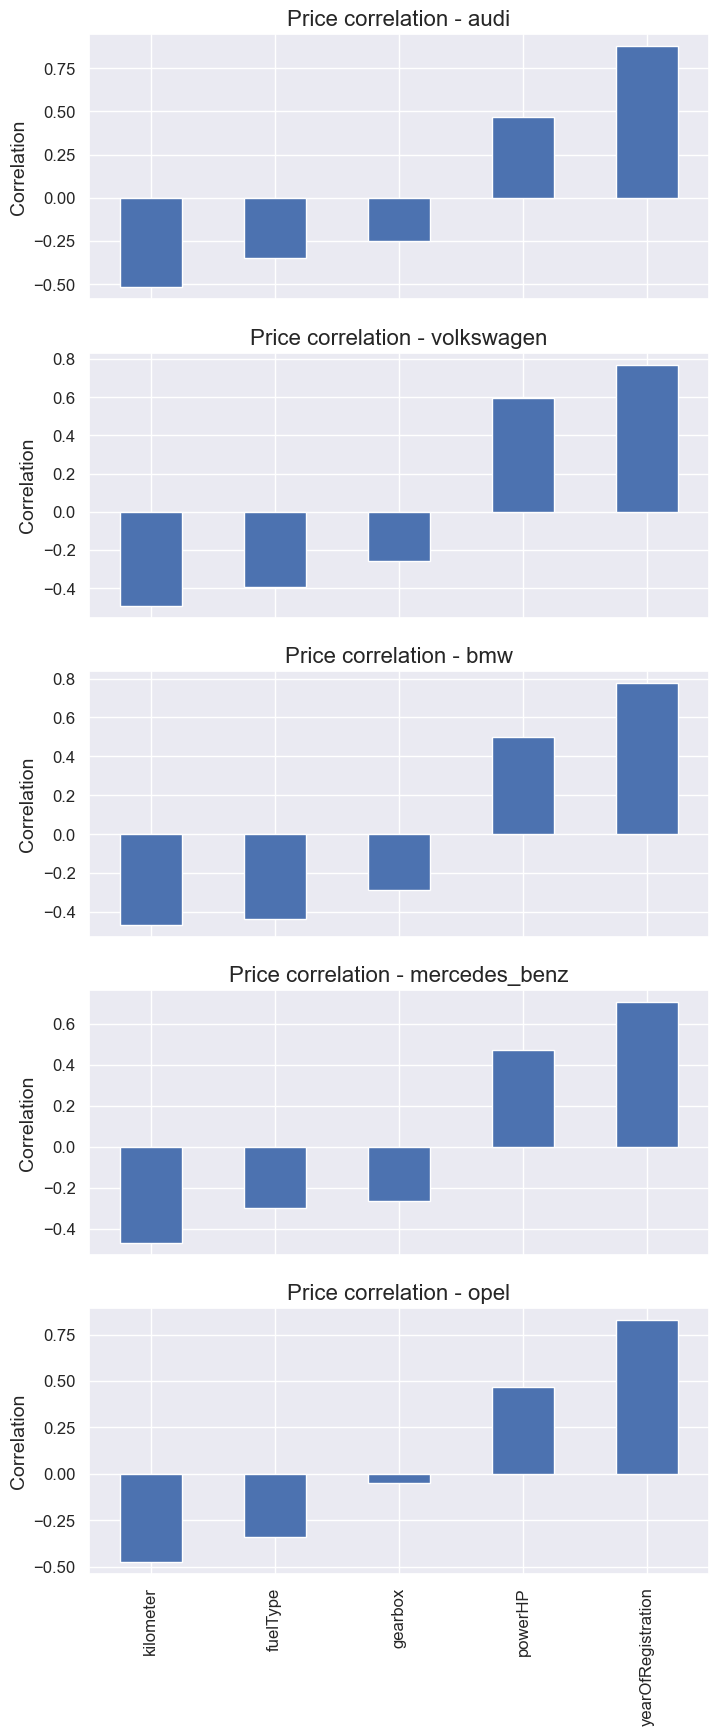

In [33]:
brands = data["brand"].unique().tolist()

fig, axes = plt.subplots(5, 1, figsize=(8, 20), sharex=True)
axes = axes.flatten()

for i, brand in enumerate(brands):
    data_brand = data[data["brand"] == brand]
    corr_df = data_brand.corr()["price"].sort_values()[:-1]
    corr_df.plot(
        kind="bar",
        ax=axes[i],
        title=f"Price correlation - {brand}",
        ylabel="Correlation",
    )

# Regression - No difference between brands

In [34]:
def plot_residuals_analysis(X_test, y_test, model, is_nn = None):
    # Generate predictions and residuals
    predictions = model.predict(X_test)
    if is_nn:
        predictions = predictions.reshape(-1)
    residuals = y_test - predictions
    
    # Calculate min and max values for plot
    min_val = min(y_test.min(), predictions.min())
    max_val = max(y_test.max(), predictions.max())

    # Print RMSE of residuals
    print(f"RMSE of residuals: {np.sqrt(mean_squared_error(y_test, predictions)):.2f}")

    # Test for homocedasticity
    # Use het_breuschpagan to test for heteroscedasticity
    lm, p, fvalue, fpvalue = het_breuschpagan(residuals, X_test)
    # Print results
    print("----HETEROCEDASTICITY----")
    print(f"Breusch-Pagan test: p-value={p:.3f}, f-value={fvalue:.2f}, fp-value={fpvalue:.3f}")
    
    # Use het_goldfeldquandt to test for heterocedasticity
    test_stat, p_value, _ = het_goldfeldquandt(residuals, X_test)
    # Print results
    print(f"Goldfeld-Quandt test: p-value={p_value:.3f}, test stat={test_stat:.2f}")

    # Test for normality using kstest
    test_stat, p_value = stats.kstest(residuals, "norm")
    # Print results
    print("----NORMALITY----")
    print(f"Skewness of residuals: {stats.skew(residuals)}")
    print(f"Kurtosis of residuals: {stats.kurtosis(residuals)}")
    print(f"Kolmogorov-Smirnov test: p-value={p_value:.3f}, test stat={test_stat:.2f}")

    # Plot results using subplots
    fig, axes = plt.subplots(1, 4, figsize=(21, 6))

    # Plot true values vs. predictions using scatterplot
    sns.scatterplot(x=y_test, y=predictions, ax=axes[0], alpha=0.15)
    axes[0].set_title("True values vs predictions")
    # Add line to indicate perfect prediction
    axes[0].plot([min_val, max_val], [min_val, max_val], c="r", lw=3)
    axes[0].set_xlabel("True values")
    axes[0].set_ylabel("Predictions")

    # Plot residuals using scatterplot
    sns.scatterplot(x=y_test, y=residuals, ax=axes[1], alpha=0.15)
    axes[1].set_title("Residuals")
    # Add line to indicate zero residual
    axes[1].plot([y_test.min(), y_test.max()], [0, 0], c="r", lw=3)
    axes[1].set_xlabel("True values")
    axes[1].set_ylabel("Residuals")

    # Plot QQ plot to test for normality
    qqplot(residuals, fit=True, line="45", ax=axes[2])
    axes[2].set_title("QQ plot")
    # Generate a normal distribution using mean and std from residuals
    mean = np.mean(residuals)
    std = np.std(residuals)
    norm_dist = stats.norm(loc=mean, scale=std)
    x_vals = np.linspace(mean - 4 * std, mean + 4 * std, 1000)
    # Calculate multiplier to overlay normal dsitribution on top of residual histogram
    counts, _ = np.histogram(residuals, bins=50)
    multiplier = max(counts) / max(norm_dist.pdf(x_vals))

    # Plot histogram of residuals
    sns.histplot(x=residuals, ax=axes[3], bins=50, kde=True)
    # Plot normal distribution on top of histogram
    axes[3].plot(x_vals, norm_dist.pdf(x_vals) * multiplier, color="red")
    axes[3].set_title("Histogram of residuals")
    axes[3].set_xlabel("Residuals")


In [35]:
TARGET = "price"
FEATURES = [
    column for column in data.columns if data[column].dtype != "O" and column != TARGET
]

X_data = data[FEATURES]
y_data = data[TARGET]

## Linear regression

/Users/albertovidalrodriguez-bobada/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RMSE of residuals: 0.46
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=1506.03, fp-value=0.000
Goldfeld-Quandt test: p-value=0.706, test stat=0.99
----NORMALITY----
Skewness of residuals: -0.1842657860618622
Kurtosis of residuals: 3.583836475434315
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.21


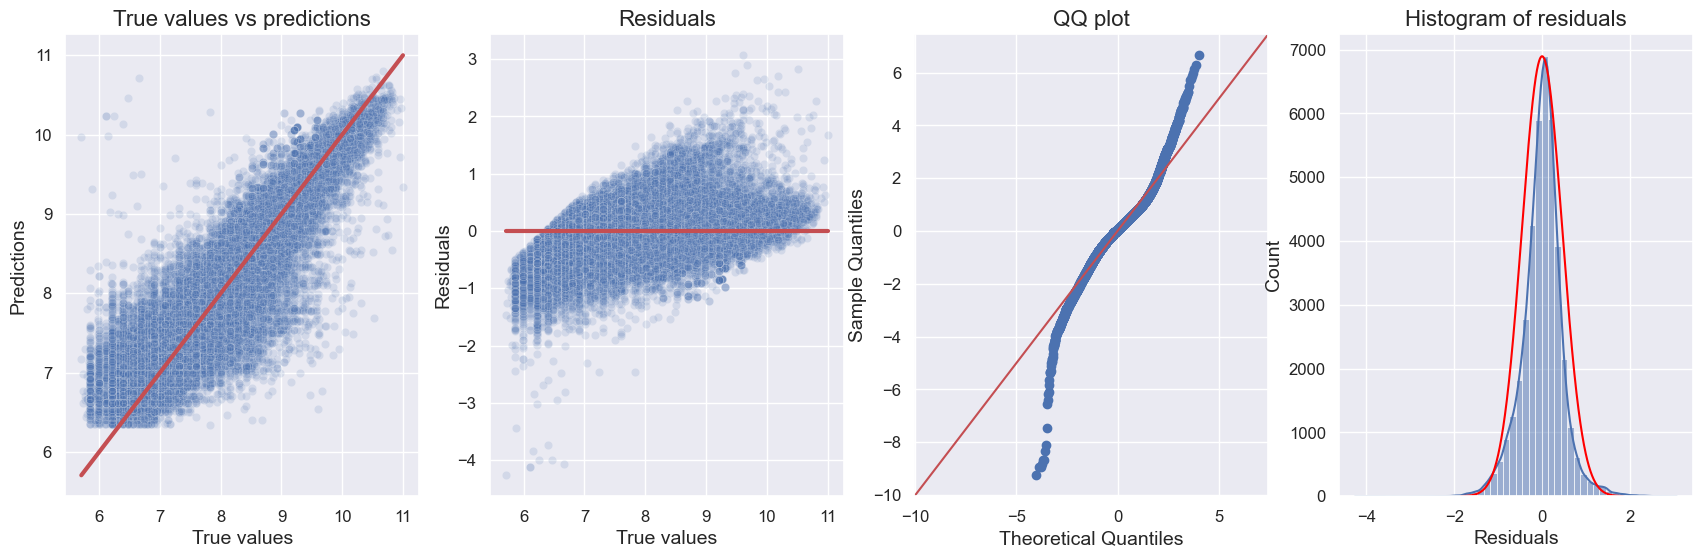

In [36]:


X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=42
)

num_splits = 5
sk_fold = KFold(n_splits=num_splits, random_state=42, shuffle=True)

# Define pipeline steps
steps = [
    ("scaler", MinMaxScaler()),
    ("pol_features", PolynomialFeatures()),
    ("model", LinearRegression()),
]

# Create pipeline object
pipeline = Pipeline(steps=steps)

param_grid = {"pol_features__degree": range(1, 8)}

search_lr = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=["neg_root_mean_squared_error", "r2"],
    refit="neg_root_mean_squared_error",
    cv=sk_fold,
    n_jobs=-1,
    verbose=0,
)

search_lr.fit(X_train, y_train);

plot_residuals_analysis(X_test, y_test, search_lr)

## XGBRegressor

RMSE of residuals: 0.43
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=1309.79, fp-value=0.000
Goldfeld-Quandt test: p-value=0.436, test stat=1.00
----NORMALITY----
Skewness of residuals: -0.312012106813393
Kurtosis of residuals: 4.48233809462671
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.23


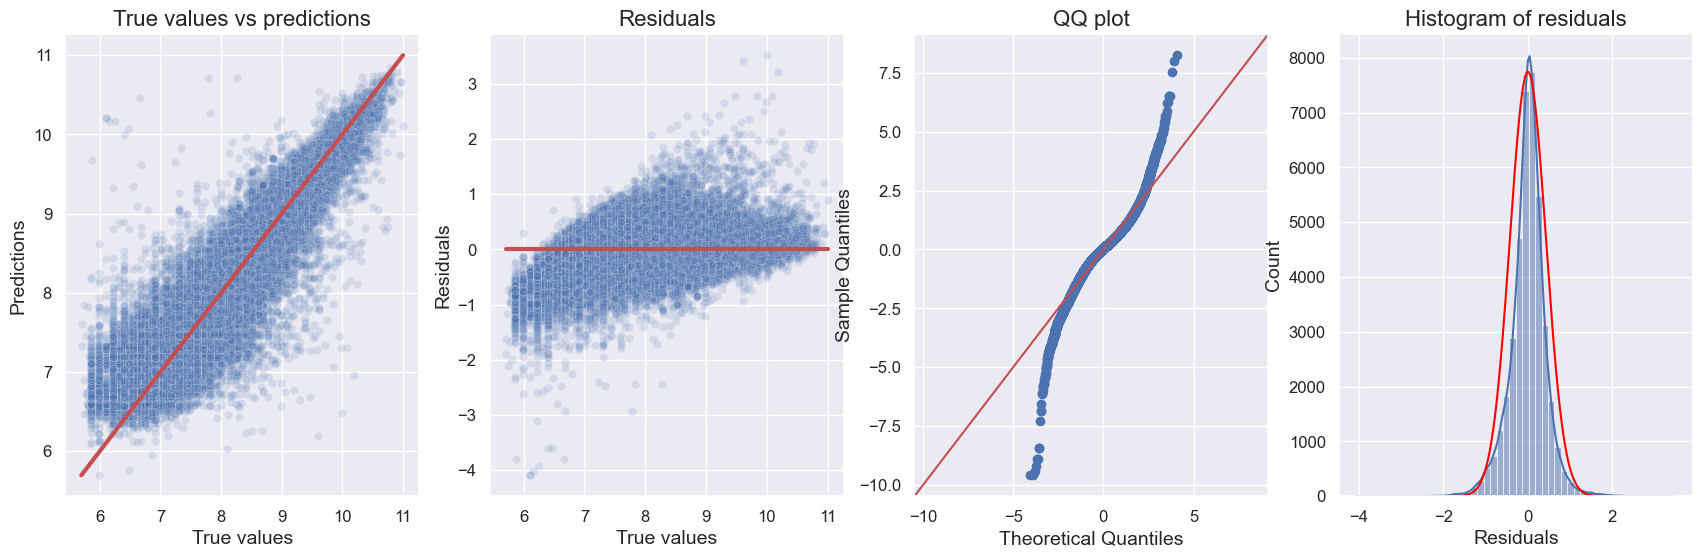

In [37]:


X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=42
)

num_splits = 5
sk_fold = KFold(n_splits=num_splits, random_state=42, shuffle=True)

# Define pipeline steps
steps = [
    ("scaler", MinMaxScaler()),
    ("pol_features", PolynomialFeatures()),
    ("model", xgb.XGBRegressor(n_estimators=250, max_depth=7)),
]

# Create pipeline object
pipeline = Pipeline(steps=steps)

param_grid = {"pol_features__degree": range(1, 3)}

search_xgb = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=["neg_root_mean_squared_error", "r2"],
    refit="neg_root_mean_squared_error",
    cv=sk_fold,
    n_jobs=-1,
    verbose=0,
)

search_xgb.fit(X_train, y_train);

plot_residuals_analysis(X_test, y_test, search_xgb)

## Decision Tree regressor

RMSE of residuals: 0.45
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=1062.06, fp-value=0.000
Goldfeld-Quandt test: p-value=0.027, test stat=1.03
----NORMALITY----
Skewness of residuals: -0.13199317104428554
Kurtosis of residuals: 5.805542736150784
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.22


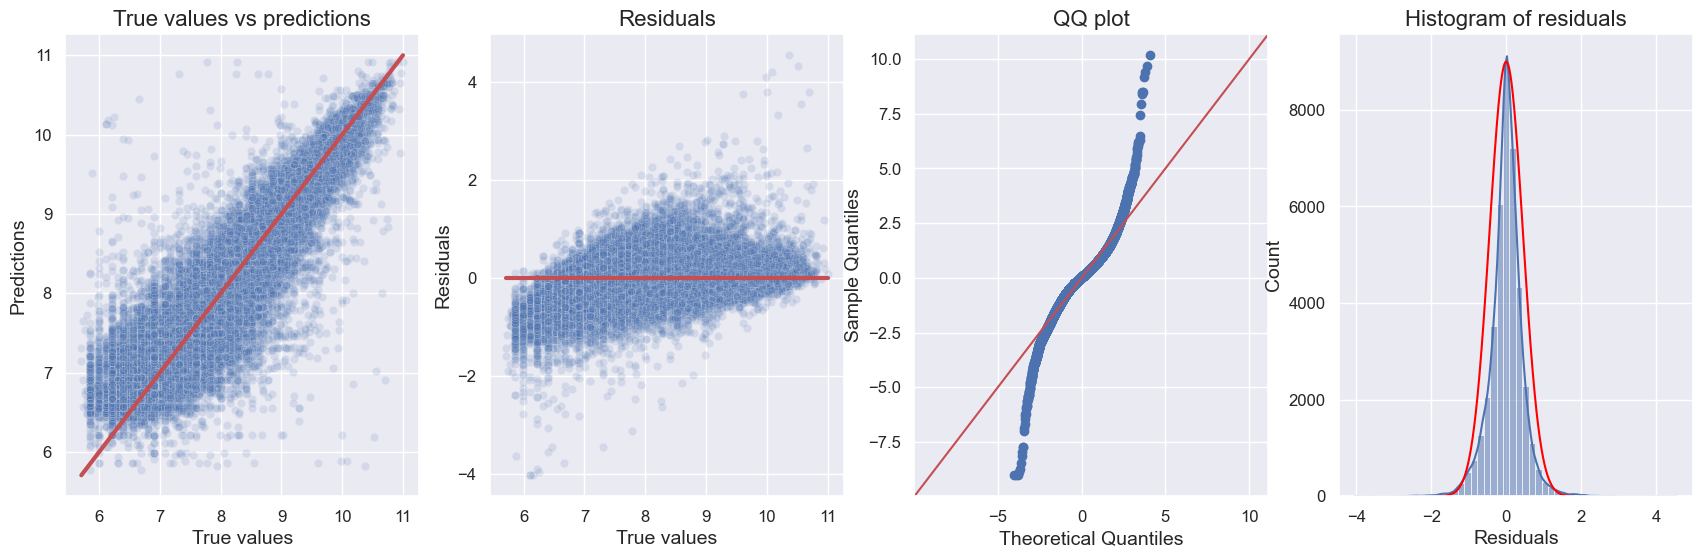

In [38]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.25, random_state=42
)

num_splits = 5
sk_fold = KFold(n_splits=num_splits, random_state=42, shuffle=True)

# Define pipeline steps
steps = [
    ("scaler", MinMaxScaler()),
    ("pol_features", PolynomialFeatures()),
    ("model", DecisionTreeRegressor(max_depth=None, random_state=42)),
]

# Create pipeline object
pipeline = Pipeline(steps=steps)

param_grid = {"pol_features__degree": range(1, 5)}

search_dt = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring=["neg_root_mean_squared_error", "r2"],
    refit="neg_root_mean_squared_error",
    cv=sk_fold,
    n_jobs=-1,
    verbose=0,
)

search_dt.fit(X_train, y_train);

plot_residuals_analysis(X_test, y_test, search_dt)


## Neural networks

In [39]:
num_features = len(FEATURES)

from keras.models import Sequential
from keras.layers import Dense
import tensorflow as tf
tf.random.set_seed(42)

# Create a neural network model with one hidden layer
model = Sequential()
model.add(Dense(8, activation="relu", input_shape=(num_features,)))
model.add(Dense(16, activation="relu", input_shape=(num_features,)))
model.add(Dense(16, activation="relu", input_shape=(num_features,)))
model.add(Dense(5, activation="relu", input_shape=(num_features,)))
model.add(Dense(1))

# Compile the model with a mean squared error loss and an Adam optimizer
model.compile(loss="mse", optimizer="adam")

# Fit the model to the training data
hist = model.fit(
    X_train,
    y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test),
)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/15


2023-04-22 13:28:05.778116: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-22 13:28:05.778409: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2023-04-22 13:28:05.961198: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-04-22 13:28:06.139693: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1878/1878 [==============================] - ETA: 0s - loss: 67790.3125

2023-04-22 13:28:16.305273: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1878/1878 [==============================] - 12s 6ms/step - loss: 67790.3125 - val_loss: 16.8795
Epoch 2/15
1878/1878 [==============================] - 12s 6ms/step - loss: 11.4244 - val_loss: 8.5404
Epoch 3/15
1878/1878 [==============================] - 11s 6ms/step - loss: 8.3408 - val_loss: 8.3187
Epoch 4/15
1878/1878 [==============================] - 11s 6ms/step - loss: 8.2256 - val_loss: 8.1535
Epoch 5/15
1878/1878 [==============================] - 11s 6ms/step - loss: 7.9620 - val_loss: 7.7595
Epoch 6/15
1878/1878 [==============================] - 11s 6ms/step - loss: 7.3575 - val_loss: 6.8893
Epoch 7/15
1878/1878 [==============================] - 11s 6ms/step - loss: 6.2323 - val_loss: 5.5264
Epoch 8/15
1878/1878 [==============================] - 11s 6ms/step - loss: 4.7895 - val_loss: 4.1005
Epoch 9/15
1878/1878 [==============================] - 11s 6ms/step - loss: 3.3984 - val_loss: 2.5805
Epoch 10/15
1878/1878 [==============================] - 13s 7ms/step - loss: 

  85/1252 [=>............................] - ETA: 2s

2023-04-22 13:31:03.512559: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1252/1252 [==============================] - 2s 2ms/step
RMSE of residuals: 0.77
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=4231.13, fp-value=0.000
Goldfeld-Quandt test: p-value=0.976, test stat=0.97
----NORMALITY----
Skewness of residuals: -0.34657006505221183
Kurtosis of residuals: 0.48560050316360437
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.16


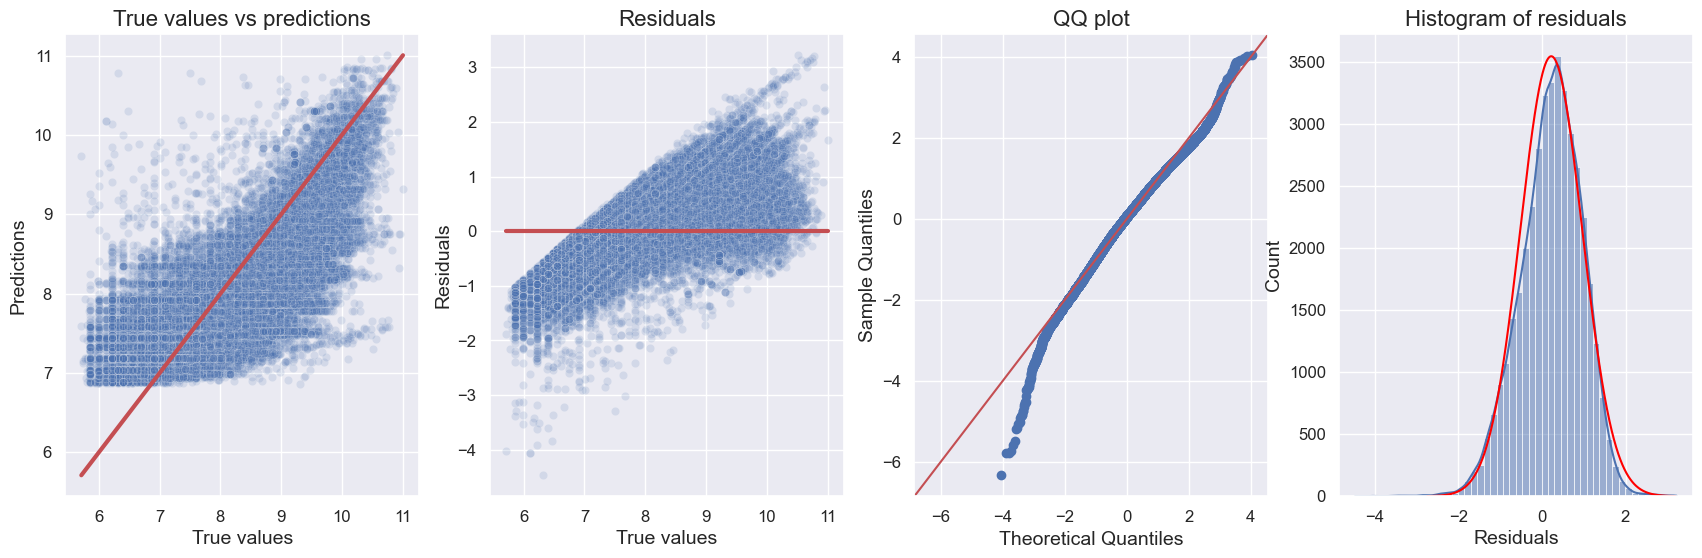

In [40]:
plot_residuals_analysis(X_test, y_test, model, True)

Despite having the ability to undercover nont-linear relationships, the output of the neural netowork is very similar to the other models.
Something worth pointing out is that, despite setting a random seed, the output of the neural network is quite different everytime I run it. This one is a fairly decent output, but, in prior runs, the ouput was the same prediction (around 8.5) for all the values.

# Regression - one model per brand

## Linear Regression

/Users/albertovidalrodriguez-bobada/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/albertovidalrodriguez-bobada/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/albertovidalrodriguez-bobada/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/albertovidalrodriguez-bobada/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/

RMSE of residuals: 0.40
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=335.06, fp-value=0.000
Goldfeld-Quandt test: p-value=0.186, test stat=1.03
----NORMALITY----
Skewness of residuals: -0.41173660234807996
Kurtosis of residuals: 2.3165053180417052
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.24
RMSE of residuals: 0.46
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=590.68, fp-value=0.000
Goldfeld-Quandt test: p-value=0.999, test stat=0.93
----NORMALITY----
Skewness of residuals: 0.070980977292579
Kurtosis of residuals: 3.1426321110818813
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.21
RMSE of residuals: 0.46
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=147.50, fp-value=0.000
Goldfeld-Quandt test: p-value=1.000, test stat=0.86
----NORMALITY----
Skewness of residuals: -0.9400981519886902
Kurtosis of residuals: 8.814363727879122
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.23
RMSE of residuals: 0.48


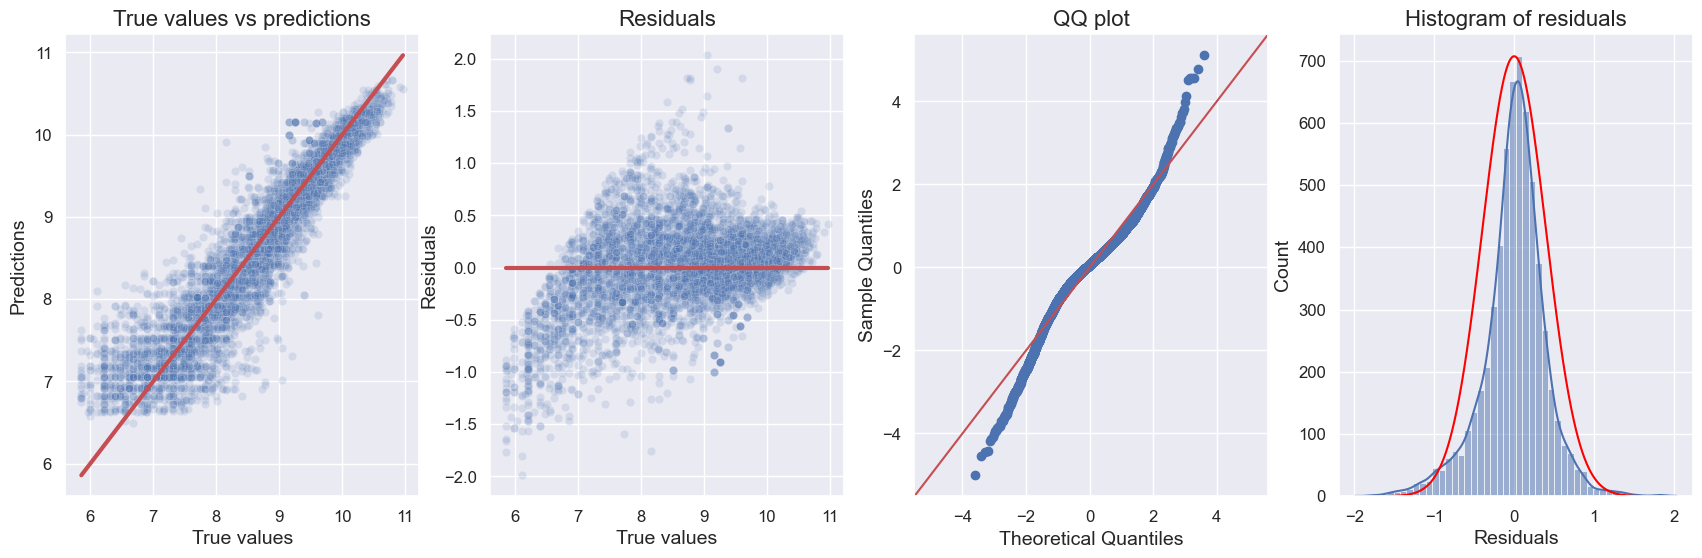

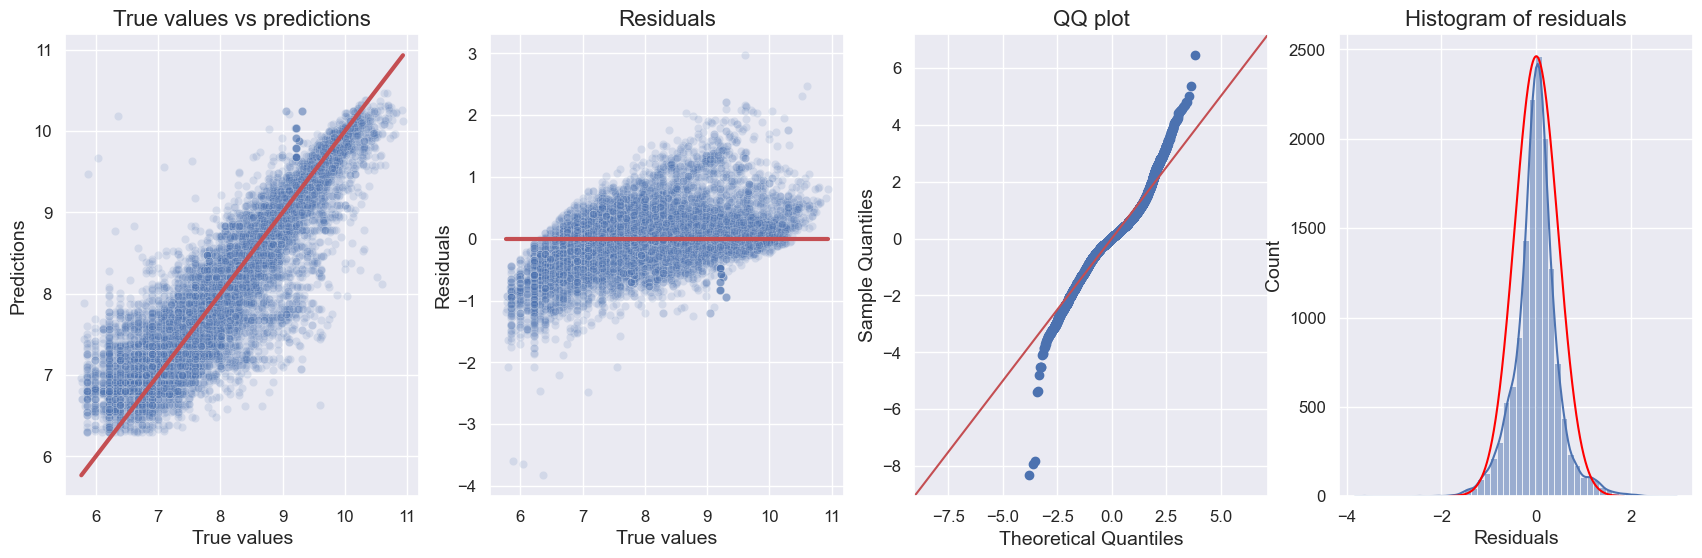

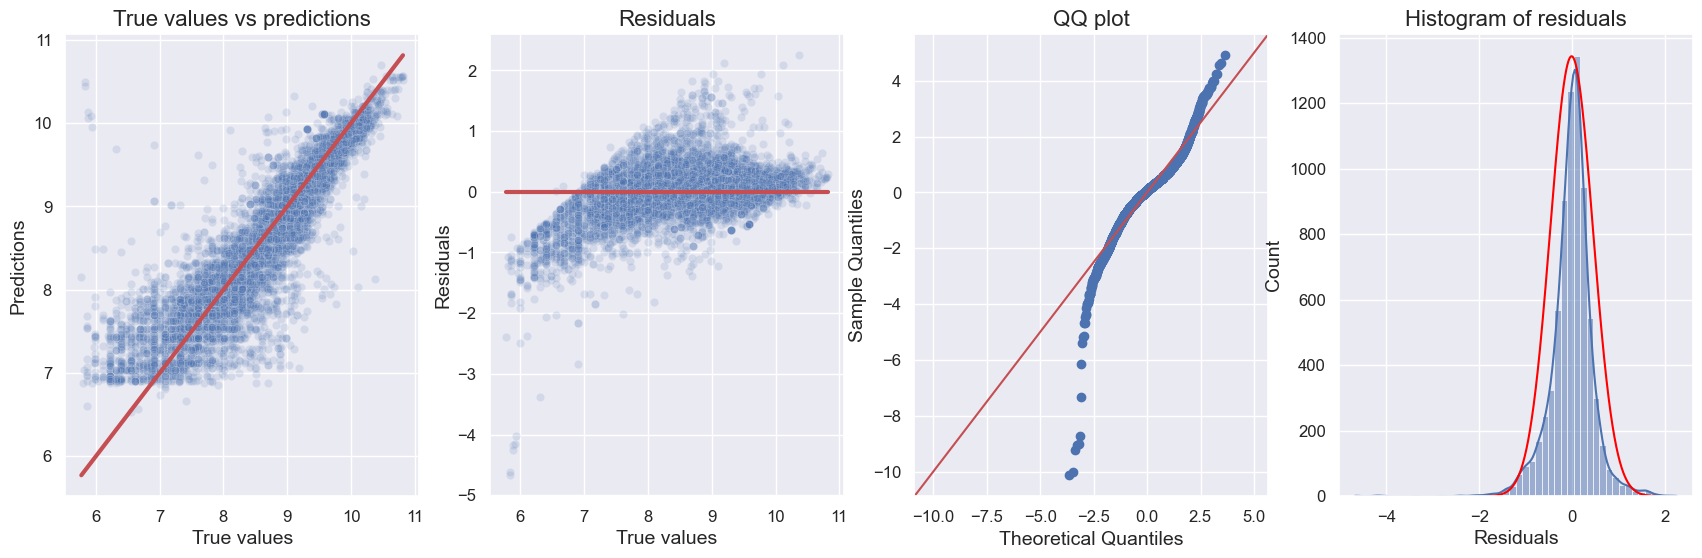

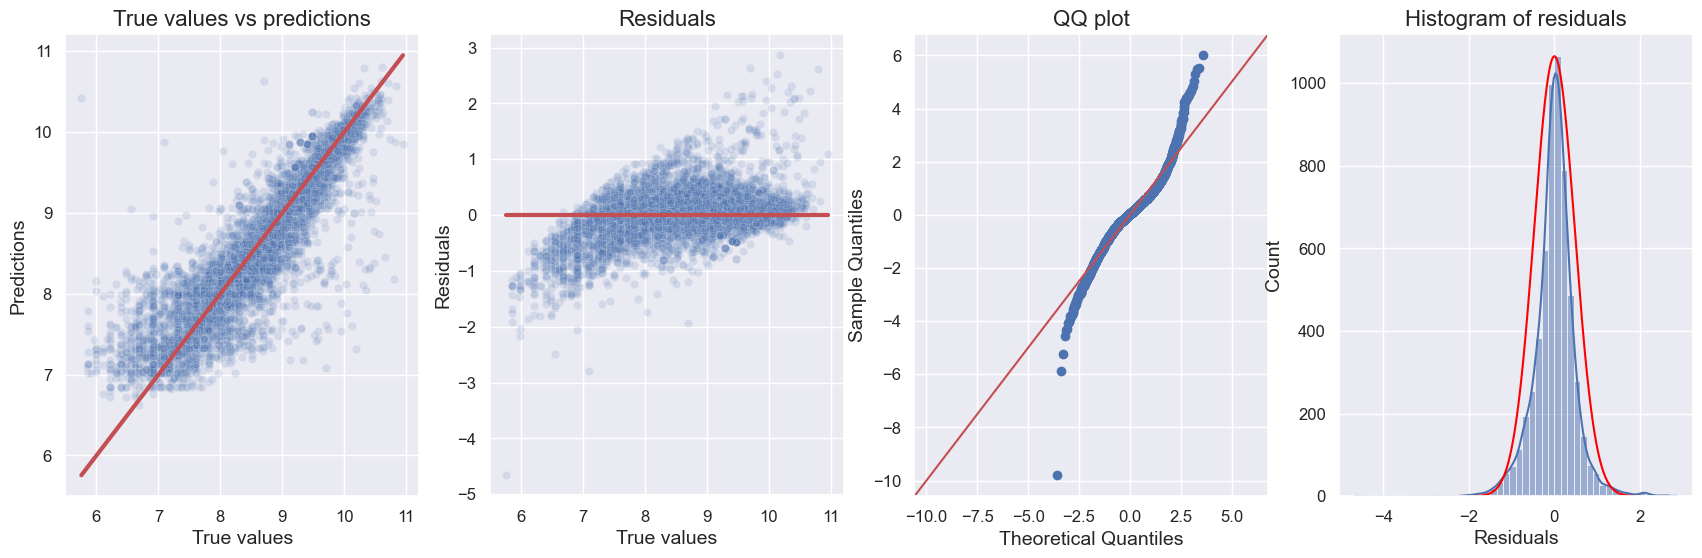

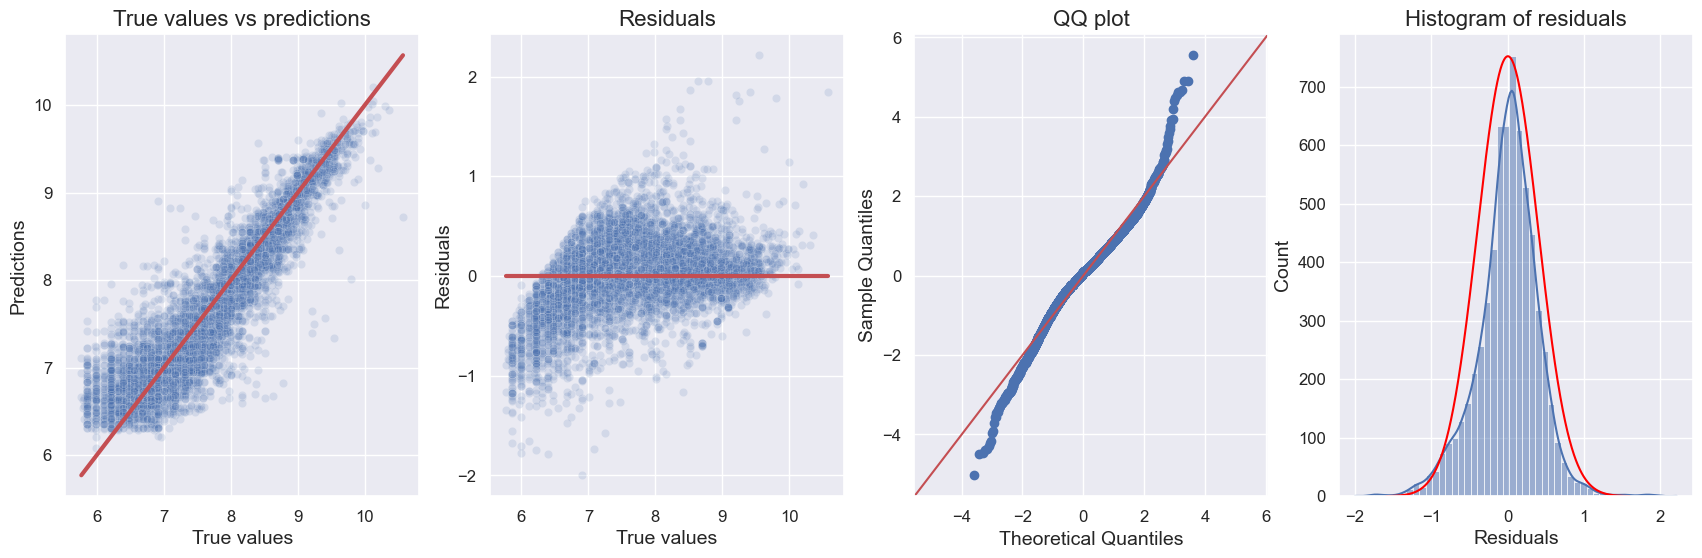

In [41]:
brands = data["brand"].unique().tolist()

models = {}
models_list = []
X_test_list = []
y_test_list = []


for i, brand in enumerate(brands):
    data_brand = data[data["brand"] == brand]

    X_data = data_brand[FEATURES]
    y_data = data_brand[TARGET]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.25, random_state=42
    )
    X_test_list.append(X_test)
    y_test_list.append(y_test)

    num_splits = 4
    sk_fold = KFold(n_splits=num_splits, random_state=42, shuffle=True)

    # Define pipeline steps
    steps = [
        ("scaler", MinMaxScaler()),
        ("pol_features", PolynomialFeatures()),
        # ("model", LinearRegression()),
        ("model", Ridge())
    ]

    # Create pipeline object
    pipeline = Pipeline(steps=steps)

    param_grid = {"pol_features__degree": range(1, 7), "model__alpha": [1,2.5,5]}

    search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=["neg_root_mean_squared_error", "r2"],
        refit="neg_root_mean_squared_error",
        cv=sk_fold,
        n_jobs=-1,
        verbose=0,
    )

    search.fit(X_train, y_train)

    models[f"{brand}_model"] = search
    models_list.append(search)

for i, (X_test, y_test, model) in enumerate(zip(X_test_list, y_test_list, models_list)):
    plot_residuals_analysis(X_test, y_test, model)

Using a model per brand leads to a worse performance for lower prices, although it seems slightly better. Still, it doesn't satisfy the assumptions of linear regression

## XGBoost Regressor

RMSE of residuals: 0.39
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=273.03, fp-value=0.000
Goldfeld-Quandt test: p-value=0.653, test stat=0.99
----NORMALITY----
Skewness of residuals: -0.3187973792706928
Kurtosis of residuals: 3.113248650000938
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.24
RMSE of residuals: 0.41
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=448.49, fp-value=0.000
Goldfeld-Quandt test: p-value=1.000, test stat=0.91
----NORMALITY----
Skewness of residuals: -0.31212885968330256
Kurtosis of residuals: 4.775053829265658
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.23
RMSE of residuals: 0.44
----HETEROCEDASTICITY----
Breusch-Pagan test: p-value=0.000, f-value=141.20, fp-value=0.000
Goldfeld-Quandt test: p-value=1.000, test stat=0.89
----NORMALITY----
Skewness of residuals: -1.0029342521565086
Kurtosis of residuals: 9.324131270520775
Kolmogorov-Smirnov test: p-value=0.000, test stat=0.23
RMSE of residuals: 0.45


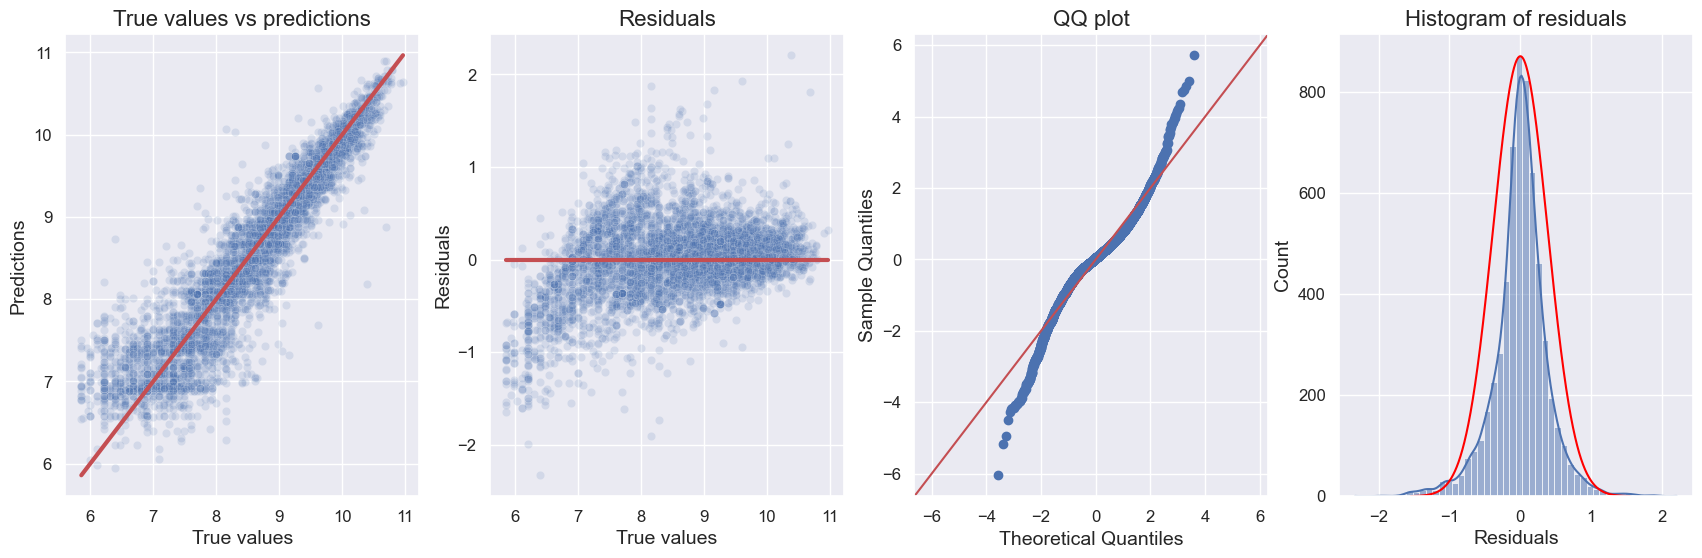

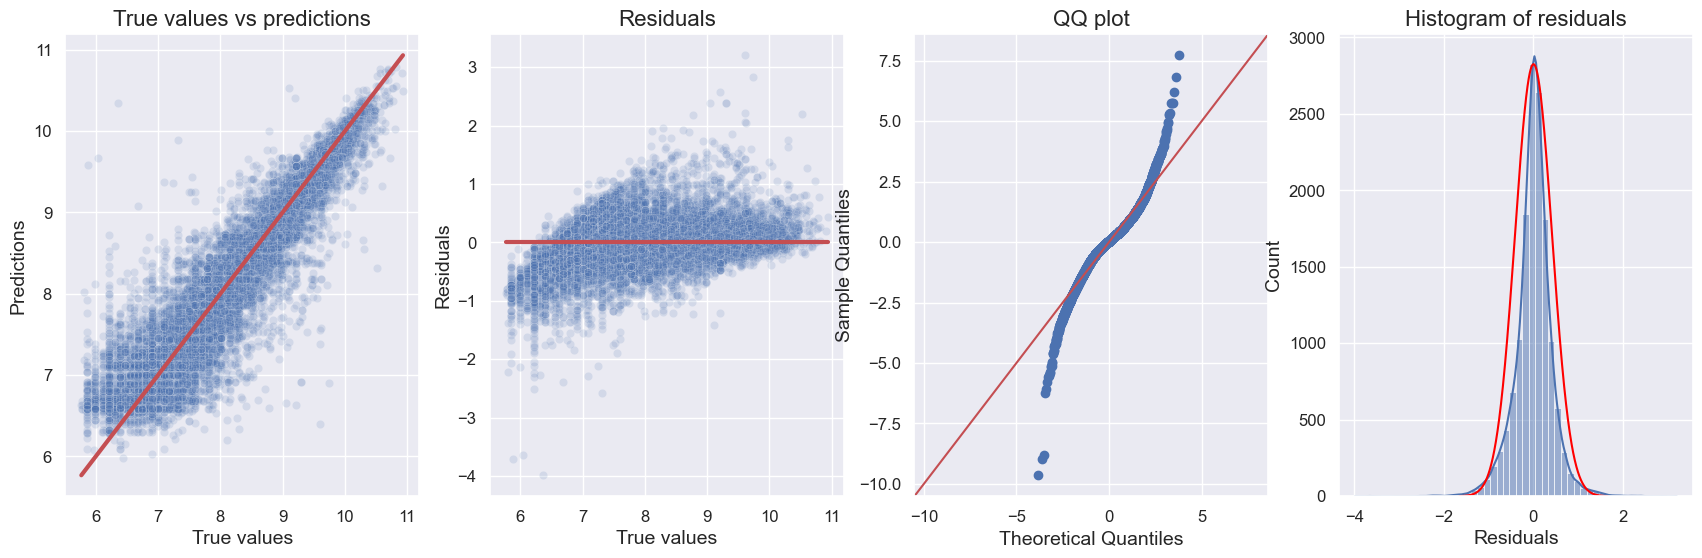

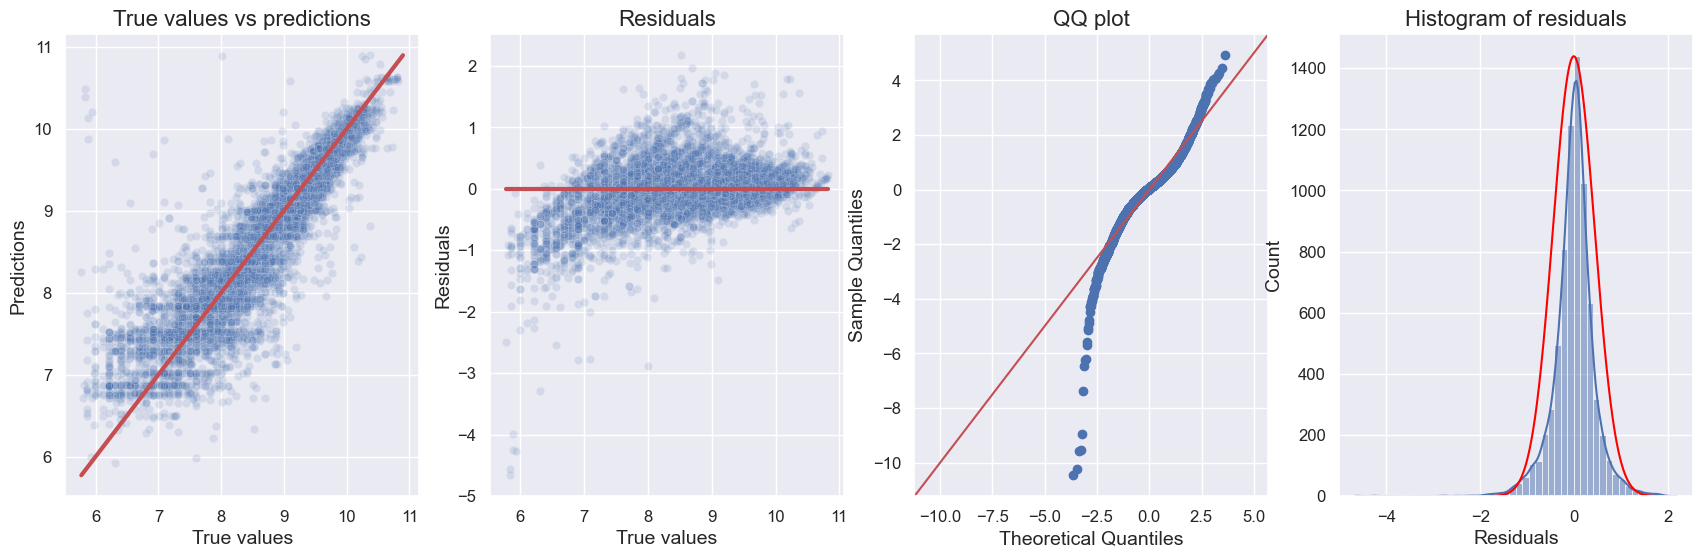

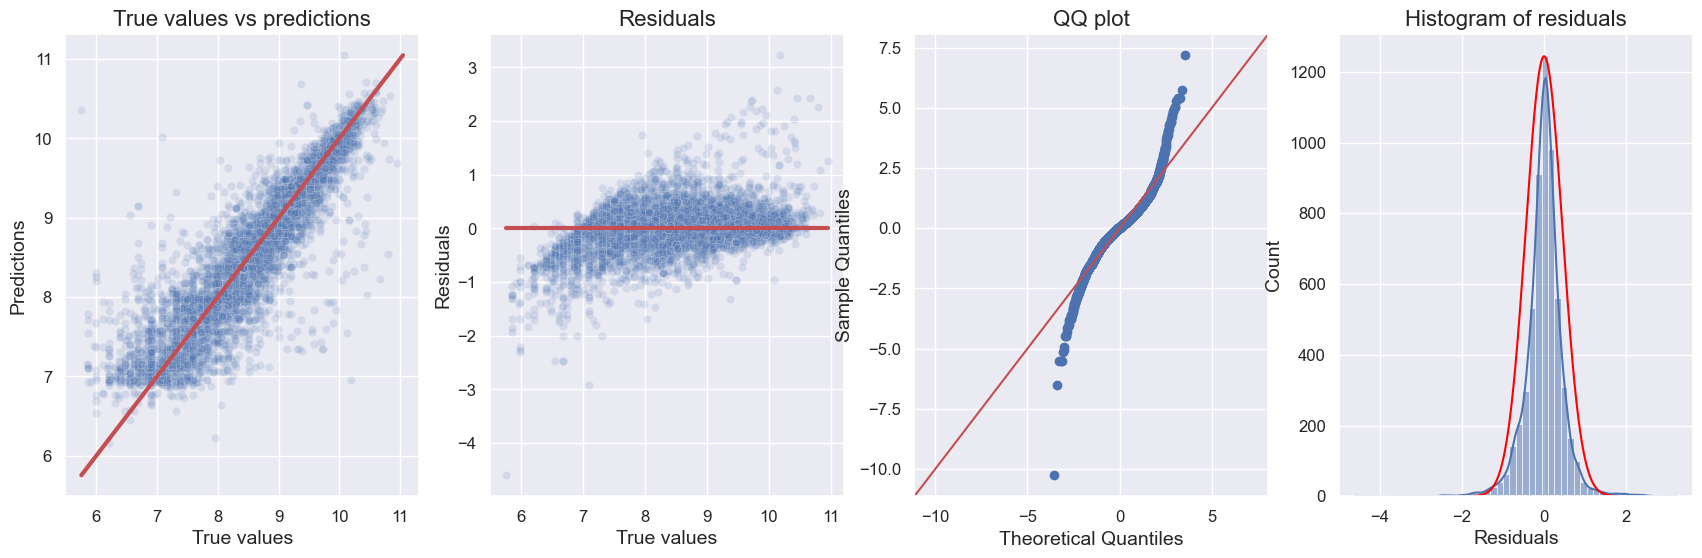

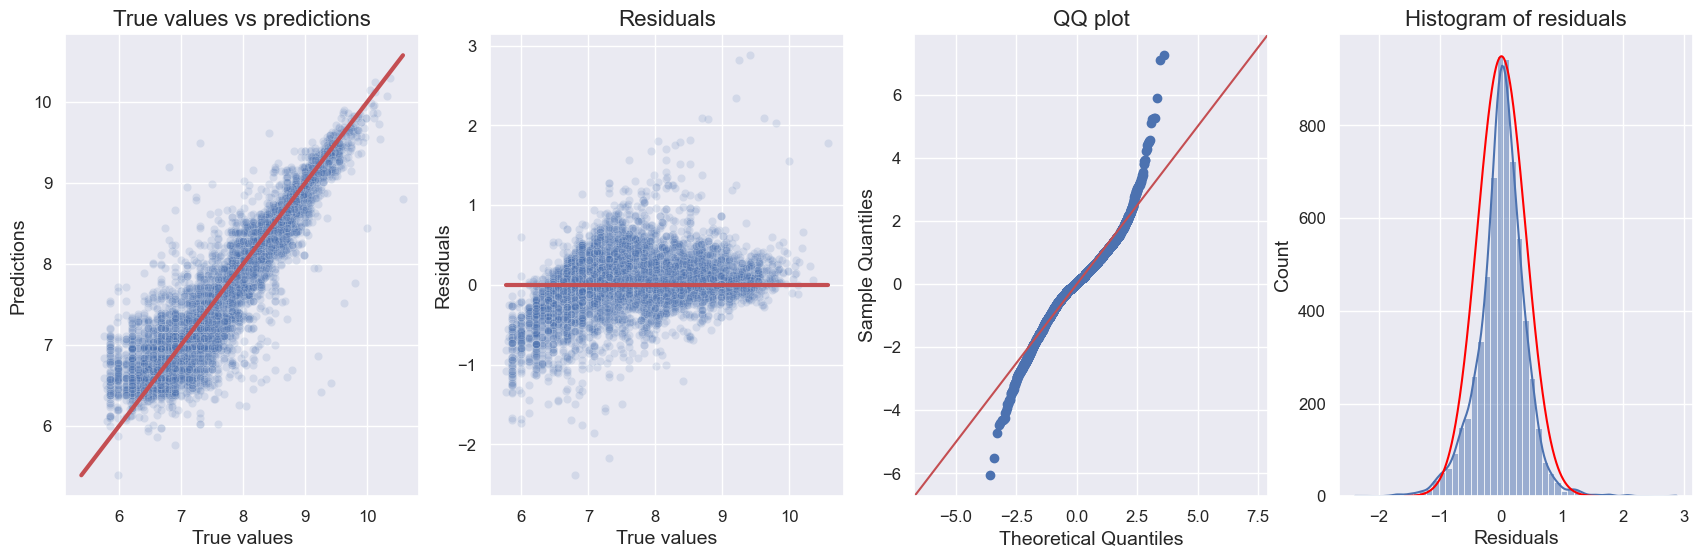

In [42]:
brands = data["brand"].unique().tolist()

models = {}
models_list = []
X_test_list = []
y_test_list = []


for i, brand in enumerate(brands):
    data_brand = data[data["brand"] == brand]

    X_data = data_brand[FEATURES]
    y_data = data_brand[TARGET]

    X_train, X_test, y_train, y_test = train_test_split(
        X_data, y_data, test_size=0.25, random_state=42
    )
    X_test_list.append(X_test)
    y_test_list.append(y_test)

    num_splits = 4
    sk_fold = KFold(n_splits=num_splits, random_state=42, shuffle=True)

    # Define pipeline steps
    steps = [
        ("scaler", MinMaxScaler()),
        ("pol_features", PolynomialFeatures()),
        # ("model", LinearRegression()),
        # ("model", Ridge())
        ("model", xgb.XGBRegressor(max_depth=6, subsample=0.75, random_state=42))
    ]

    # Create pipeline object
    pipeline = Pipeline(steps=steps)

    param_grid = {"pol_features__degree": range(1, 3), "model__n_estimators": [200]}

    search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        scoring=["neg_root_mean_squared_error", "r2"],
        refit="neg_root_mean_squared_error",
        cv=sk_fold,
        n_jobs=-1,
        verbose=0,
    )

    search.fit(X_train, y_train)

    models[f"{brand}_model"] = search
    models_list.append(search)

for i, (X_test, y_test, model) in enumerate(zip(X_test_list, y_test_list, models_list)):
    plot_residuals_analysis(X_test, y_test, model)

Having seen all the results, no model is suitable for predicting car prices. All of the models are underfitting, even neural networks, which can unveil non-linear relationships. This means that linear regression isn't the problem, but the lack of informative features is. Using 5 features isn't to capture the complexity of the underlying relationships between car price and car features. Therefore, I will create another notebook where I use one-hot-encoding on the car brand.